In [28]:
import lightnet as ln
import cv2
import os
import numpy as np
import brambox as bb
import pandas as pd
from dataset import MlDetectionTrainData, MlDetectionValidData, MlDetectionTestData, get_video_frame_paths
import utils
import torch
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

In [15]:
# define params
params = ln.engine.HyperParameters(
    # Network
    input_dimension = (32, 24),
    batch_size = 1,
    mini_batch_size = 1,
    max_batches = 50000,
    use_background_image = True,
    subtract_background_image = False,
    diff_channel_stride = 5,

    # Dataset
    _train_set = '../data/video/meta/train.txt',
    _valid_set = '../data/video/meta/val.txt',
    _test_set = '../data/video/meta_test/all_45.txt',
    min_bbox_area_train = 15,
    min_bbox_area_test = 15,

    # dataset preprocessing type
    color=False,

    # Temperature range sensor
    min_value = 0,
    max_value = 10000,  # divide by 100 to get degrees
    
    # Thermal dataset statistics
    mean = 2237,
    std = 155,

    # Data Augmentation
    contrast = .0,
    brightness = .00,
    hflip = .5,
    vflip = .5,
    noise = 0.0,
    temporal_scale = 0.0,
)

In [16]:
#dataset = MlDetectionValidData(params, False, '../data/video')

dataset = MlDetectionTrainData(params, True, '../data/video')
#dataset = MlDetectionTestData(params, False, '../data/video')

INFO         Parsing annotations
100%|██████████| 173/173 [00:17<00:00, 10.01it/s]
INFO         Creating background images
100%|██████████| 173/173 [01:49<00:00,  1.58it/s]


In [17]:
len(dataset)

75879

In [18]:
loader = ln.data.DataLoader(
        dataset,
        batch_size = params.mini_batch_size,
        shuffle = True,
        drop_last = True,
        num_workers = 0,
        collate_fn = utils.brambox_collate,
    )

In [35]:
def norm_image(tensor):
    max_value = tensor.max()
    min_value = tensor.min()
    #print(max_value, min_value, tensor.mean(), tensor.std())
    image_data = ((tensor - min_value) / (max_value - min_value)).numpy()
    # covert float32 grayscale to 8-bit
    image_data = (image_data * 255).astype(np.uint8)
    return image_data
    
def visualize_samples_paper(tensor, annos):
    
     for i, image_channels in enumerate(tensor):
        anno = annos[annos['batch_number'] == i]

        image, bg = image_channels[:2]
        image_channels = torch.stack([image, image-bg])
        image_channels = norm_image(image_channels)
        image, image_min_bg = image_channels
        
        fig = plt.figure(figsize=(15, 5))
        title = f'{anno.image.cat.categories[i]}'
        plt.title(title)
        fig.add_subplot(1, 3, 1)
        plt.imshow(image)
        fig.add_subplot(1, 3, 2)
        plt.imshow(image_min_bg)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = bb.util.draw_boxes(image, anno, method=bb.util.DrawMethod.CV, size=1)
        fig.add_subplot(1, 3, 3)
        plt.imshow(image)
    
def visualize_data(tensor, annos):
    # normalize for visualization
    max_value = tensor.max()
    min_value = tensor.min()
    #print(max_value, min_value, tensor.mean(), tensor.std())
    image_data = ((tensor - min_value) / (max_value - min_value)).numpy()
    # covert float32 grayscale to 8-bit
    image_data = (image_data * 255).astype(np.uint8)
    
    for i, image_channels in enumerate(image_data):
        anno = annos[annos['batch_number'] == i]

        image = image_channels[0]
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        #anno = anno[anno.ignore == False]
        # draw annotations
        image = bb.util.draw_boxes(image, anno, method=bb.util.DrawMethod.CV, size=1)
        
        fig = plt.figure(figsize=(15, 5))
        title = f'{anno.image.cat.categories[i]}'
        plt.title(title)
        fig.add_subplot(1, len(image_channels), 1)
        plt.imshow(image)
        
        for i, c in enumerate(image_channels[1:]):
            fig.add_subplot(1, len(image_channels), i+2)
            plt.imshow(c)


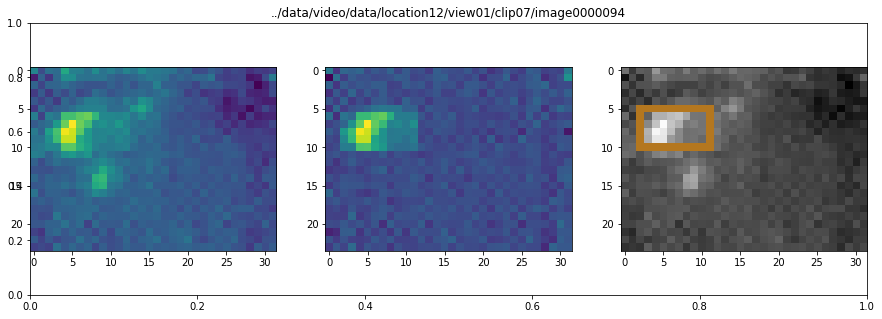

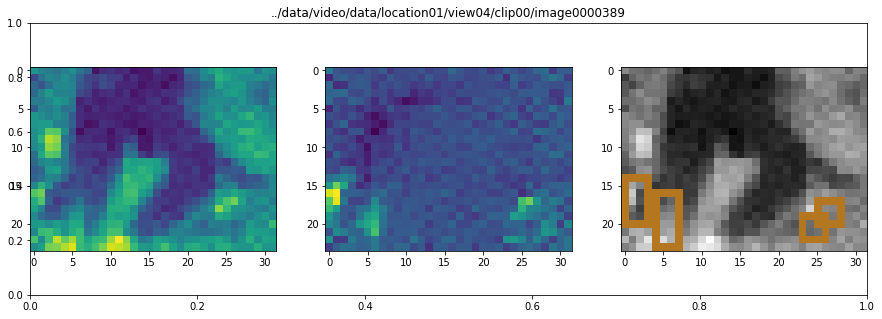

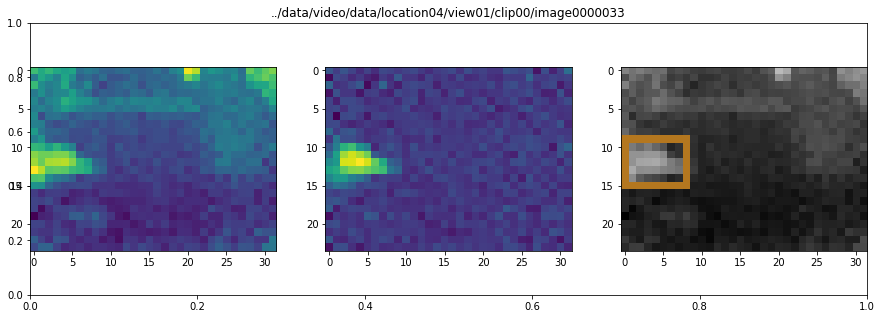

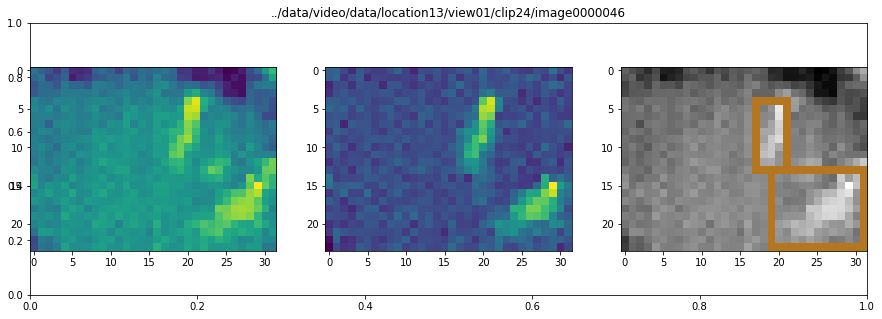

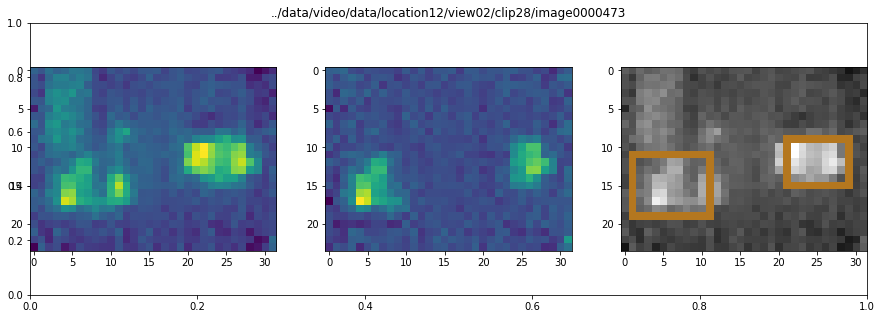

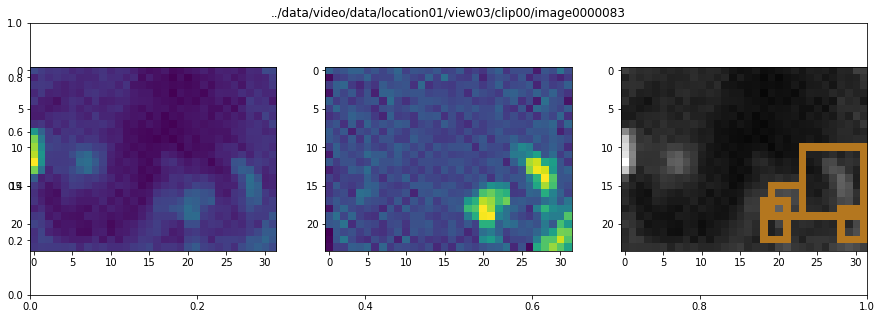

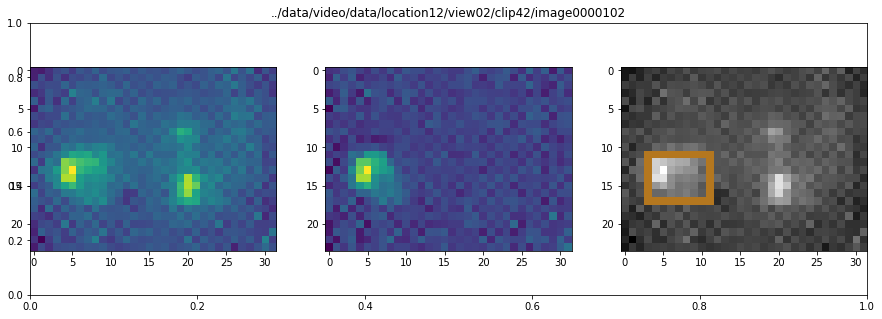

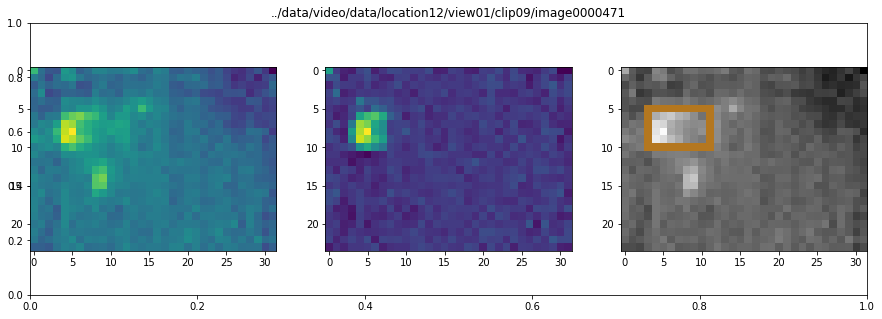

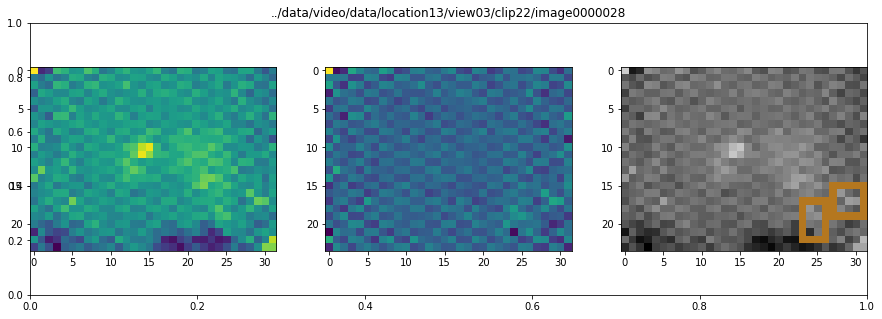

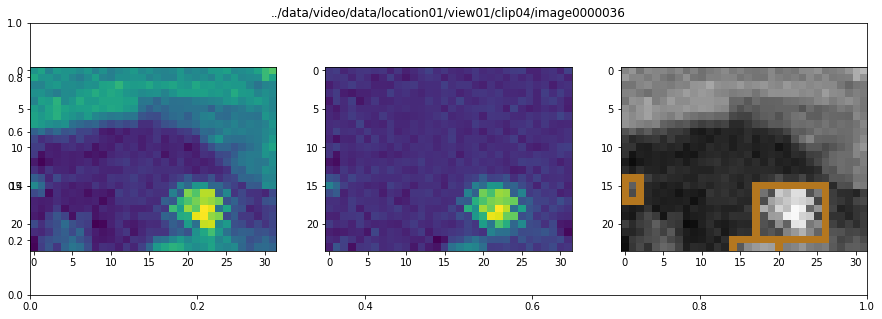

In [40]:
motion_x_values = []
motion_y_values = []
for i, (data, target) in enumerate(loader):
    if i == 10:
        break
    visualize_samples_paper(data, target)